# Introduction

In this document, Let's try to have a look at lookup performance of
two (very) different C++ hash tables:

* The C+11 standard unordered map;
* The google dense hash map.

The hash table listed above are very different in terms of implementation; 

* In, the first solution, there is a linked list in each bucket of the
  hash table; it is a straightforward way to handle hash collision cases.
* In, the dense map implementation, collision is managed differently:
  if, after having "hashed" an item, the resulting bucket "n" is not
  free, the algorithm will check the buckets "n + 1", "n + 2", "n +
  4", etc.

Let's try to understand the differences in terms of performance for
these 2 approaches.

In this document will only deal with a specific use-case: lookup operations.

NOTE: as this study is very limited, it might be normal if one
solution provides significantly lower performance; the design might
have been done with concerns other than only lookup.


# Description of the test environment

Here are some details on the bench machine:

* CPU: Intel Core i5-6200U @ 2.30 GHz
* RAM: 16GB
* System: Arch (linux-4.6.4, glibc-2.33)
* Cpufreq governor: performance: the pstate power scaling driver is
  used; so the CPU frequency cannot be statically set with a
  user-space tool.
```
# cpupower frequency-set -g performance
```

## Implementation details

# Lookup Benchmark

## Benchmark description

Once more the benchmark is very simple:

* Insert 1 million entries into the hash table; an entry is a tuple of
  2 64bit unsigned integer values (1 for the key and 1 for the value).
* Perform 20 million (more precisely: 20480000) of lookup operations
  with a pre-filled set of 4096 random values;

This benchmark will be performed on both containers
(std::unordered_map and google::dense_map).

## Basic time results

Standard unordered map:

```
$ time taskset 0x1 ./benchmark/bench__lookup std_unordered_map 1000000
Hash table description:
  Bucket count: 1056323
 load factor: 0.94668

real	0m0.362s
user	0m0.350s
sys	0m0.010s
```

Google dense hash map:

```
$ time taskset 0x1 ./benchmark/bench__lookup google_dense_map 1000000
Hash table description:
Bucket count: 2097152

real	0m0.071s
user	0m0.060s
sys	0m0.010s
```

Summary:

* std::unordered_map user time: 0m0.350s
* google::dense_map user time: 0m0.060s

Points to keep in mind:

* The google dense map outchmatches the standard unordered map by nearly
  a factor 6 !!!
* The standard unordered map was working with a set of about 1 million
  of buckets; there were about 0.9 element per bucket; so, a fairly
  good configuration.
* The Google dense map was working with bucket set twice larger than
  the standard one;
* However, the dense map solution seems far better for lookup.
  
Let's try to understand a little bit more the situation
  with a basic perf stat commands.

## Perf stat output

Standard unordered map:

```
$ perf stat -- ./benchmark/bench__lookup std_unordered_map 1000000
...

 Performance counter stats for './benchmark/bench__lookup std_unordered_map 1000000':

        389.723838      task-clock:u (msec)       #    0.998 CPUs utilized          
                 0      context-switches:u        #    0.000 K/sec                  
                 0      cpu-migrations:u          #    0.000 K/sec                  
              9890      page-faults:u             #    0.025 M/sec                  
         984706928      cycles:u                  #    2.527 GHz                    
         735944857      instructions:u            #    0.75  insn per cycle         
         143928004      branches:u                #  369.308 M/sec                  
             17380      branch-misses:u           #    0.01% of all branches        

       0.390440585 seconds time elapsed
```

Google dense hash map:

```
$ perf stat -- ./benchmark/bench__lookup google_dense_map 1000000
...

 Performance counter stats for './benchmark/bench__lookup google_dense_map 1000000':

         72.934519      task-clock:u (msec)       #    0.992 CPUs utilized          
                 0      context-switches:u        #    0.000 K/sec                  
                 0      cpu-migrations:u          #    0.000 K/sec                  
              3208      page-faults:u             #    0.044 M/sec                  
         171365033      cycles:u                  #    2.350 GHz                    
         577486832      instructions:u            #    3.37  insn per cycle         
         144986807      branches:u                # 1987.904 M/sec                  
             16708      branch-misses:u           #    0.01% of all branches        

       0.073519715 seconds time elapsed
```

Points to keep in mind:

* Google dense map solution manages to execute 3.4 instructions per
  cycle while the standard solution does not even reach 1 instruction
  per cycle (0.75);
* Google dense map solution 577 milions of instructions while the
  standard one executes 736 millions of instructions;
* Google dense map used twice more buckets but less page fault
  occurred (3208 instead of 9890; ratio: 3).

So, it seems critical to understand why google dense map displays a
far better "insn / cycle" ratio; maybe, the explanation is in the
cache / memory usage.

## Output of perf stat with cache-related events

Standard unordered map:

```
$ perf stat -e cache-misses -e cache-references -e L1-dcache-load-misses -e L1-dcache-loads -e LLC-load-misses -e LLC-loads  -- ./benchmark/bench__lookup std_unordered_map 1000000
Bucket count: 1056323 load factor: 0.94668
Missing lookup: 0

 Performance counter stats for './benchmark/bench__lookup std_unordered_map 1000000':

           5219247      cache-misses:u            #    2.592 % of all cache refs      (66.39%)
         201380641      cache-references:u                                            (66.39%)
          82335952      L1-dcache-load-misses:u   #   50.31% of all L1-dcache hits    (66.39%)
         163648265      L1-dcache-loads:u                                             (67.01%)
            142768      LLC-load-misses:u         #    0.26% of all LL-cache hits     (67.60%)
          54863003      LLC-loads:u                                                   (66.98%)

       0.375688759 seconds time elapsed
```

Google dense hash map:

```
$ perf stat -e cache-misses -e cache-references -e L1-dcache-load-misses -e L1-dcache-loads -e LLC-load-misses -e LLC-loads  -- ./benchmark/bench__lookup google_dense_map 1000000
Bucket count: 2097152
Missing lookup: 0

 Performance counter stats for './benchmark/bench__lookup google_dense_map 1000000':

           1641511      cache-misses:u            #    3.314 % of all cache refs      (66.75%)
          49526211      cache-references:u                                            (66.75%)
          23920898      L1-dcache-load-misses:u   #   47.89% of all L1-dcache hits    (66.75%)
          49947836      L1-dcache-loads:u                                             (66.75%)
             20077      LLC-load-misses:u         #    0.12% of all LL-cache hits     (67.82%)
          16541977      LLC-loads:u                                                   (67.82%)

       0.072582388 seconds time elapsed

```

Points to keep in mind:

* Cache-misse ratios are fairly the same between the 2 hash tables;
* Google dense map generates far less cache loads / references: 50
  miliions instead of 200 millions; there is a factor 4!!!

Now, let's check the reason behin this factor 4. Is it because the
standard unordered map allocates more data?

## Heap allocation details thanks to mallinfo

Standard unordered map:

```
$ ./benchmark/bench__lookup std_unordered_map 1000000
Hash table description:
  Bucket count: 1056323
 load factor: 0.94668
Allocation description:
  arena space:32120832
  free chunks:1
  free fastbins:0
  mmap regions:1
  mmap space:8454144
  max alloc space:0
  free fastbins space:0
  total alloc space:32073888
  total free space:46944
  keepcost space:46944
```

Google dense hash map:

```
$ ./benchmark/bench__lookup google_dense_map 1000000
Hash table description:
  Bucket count: 2097152
Allocation description:
  arena space:204800
  free chunks:1
  free fastbins:0
  mmap regions:1
  mmap space:33558528
  max alloc space:0
  free fastbins space:0
  total alloc space:73792
  total free space:131008
  keepcost space:131008
```

Points to keep in mind:

* For the standard unordered map, nearly all the allocations are done
  in the arena (in the other words the heap); that means that many
  small-sized allocations are performed; the total allocation size in
  the arena is worth 32MB;
* For the Google dense map, nearly all the allocation(s) are performed
  outside of the heap because the allocation(s) were too large to
  alter the libc's heap; by default, allocations greater than 1MB are
  handled separately: the libc triggers a mmap syscall; nearly 34MB
  were allocated in the mmap area;
* Even if Google's map allocates twice more buckets than the standard
  map does, the memory footprints are pretty similar (32 against
  34MB);	    

# Some conclusions on the lookup benchmark

* For lookup operations, Google's version outperforms the STL C++11
  one by a factor of 6;
* The Google dense hash map has an interesting "instructions / cycle"
  ratio: 3.4 (against 0.75 for the standard version);
* The Google designer choice (no linked list) saves many CPU resources:

** There are less executed instructions;
** There are 4 times less memory load operations;

If we step back a little bit, we will understand that this benchmark
proves nothing interesting except that pointer manipulation is far
from being free.

So, this benchmark is a dummy way to assess the minimal cost of a
linked list mechanism (with a load factor of 0.95, the reader can
reasonably assume that there were less than 3 elements per bucket, so
per linked list);

Nevertheless, the reader can, at least, get an accurate idea on the
cost of a lookup in :
* a link-list enabled hash table: 17ns;
* a dense hash table: 2.9ns;

These numbers are really surprising... so low that it might be worth
having a second look. It might be interesting having a look at the
default hash function of a 64bits integer value...

Finally, the benchmark above is no help for having a look at the
performance of the hash tables in case recurrent collision; the
containers were resized so that nearly no collision occurs.

# Insertion benchmark

For the benchmarks above, the insertion operations (to fill the hash
table before the benchmarked lookup) were considered negligible. It is
now time to check whether this assertion was correct.

## Benchmark description

The goal of this benchmark is not to evaluate the various hash resize
algorithms or their implementations; the study is simply focused on
the interest (or not) of a dense table over a sparse version. So,
before any insertion the hash table will be properly resized.

In the former benchmark, 1 millions of entries were inserted in the
hash tables; these entries were not randomly generated (the goal was
to fill the hash table as quick as possible); here, 10 millions of
randomly-generated elements will be inserted; so, it might be
interesting to measure the time needed to fill a vector of 10 millions
of random numbers. the execution time of this preparation step will be
substracted from the whole insertion times. The same operations will
be done for the calculation of the memory footprints.

In order to prevent rehashing-related noise, the maps were correctly
sized so that no resizing / rehashing occurs during the insertions.

## Basic time results

Basic execution times:

Preparation step:

```
$ time ./benchmark/bench__insert prepare 10000000
...
real	0m0.231s
user	0m0.227s
sys	0m0.003s
```

Standard unordered map:

```
$ time ./benchmark/bench__insert std_unordered_map 10000000
...
real	0m0.836s
user	0m0.743s
sys	0m0.090s
```

Google dense map:

```
$ time ./benchmark/bench__insert google_dense_map 10000000
...
real	0m0.274s
user	0m0.240s
sys	0m0.033s
```

So, here are the insertion times once preparation time values are
substracted:

* std_unordered_map: real: 0.605s, user: 0.516s, sys: 0.087s
* google_dense_map:  real: 0.043s, user: 0.013s, sys: 0.030s

Once more, the google dense map prevails by far over the standard
unordered map. 

## Memory footprint, perf stat results, etc.

In order to save time, the mallinfo and perf stat output will not be
printed; as the results can be easily guessed:

* Far less instructions are executed by the google dense map in this
  insert scenario;
* The google dense map allocates one (virtually) contiguous memory
  area thanks to mmap; nearly nothing is allocated in the heap:arena;
* The google dene map allocates 3 times more buckets but the global
  memory usage (mmap + arena) is less than twice the memory usage of
  the standard unordered map;
* Google dense map's bucket allocation policy is expensive; calling
  map.resize(10 millions) will allocate 3O millions of buckets.
  
## Looking for a hard case,for Google dense map

The standard unordered map is a sparse hash table: the bucket table
does not contain key-value items byt pointers to key-value items; so,
with a large bucket array of large items (either key, value or both),
we tend to save space;

So let's try to benchmark the insertion times of a structure which
size significantly changes along the tests. Please find the execution
times results summarized in the diagrams below.

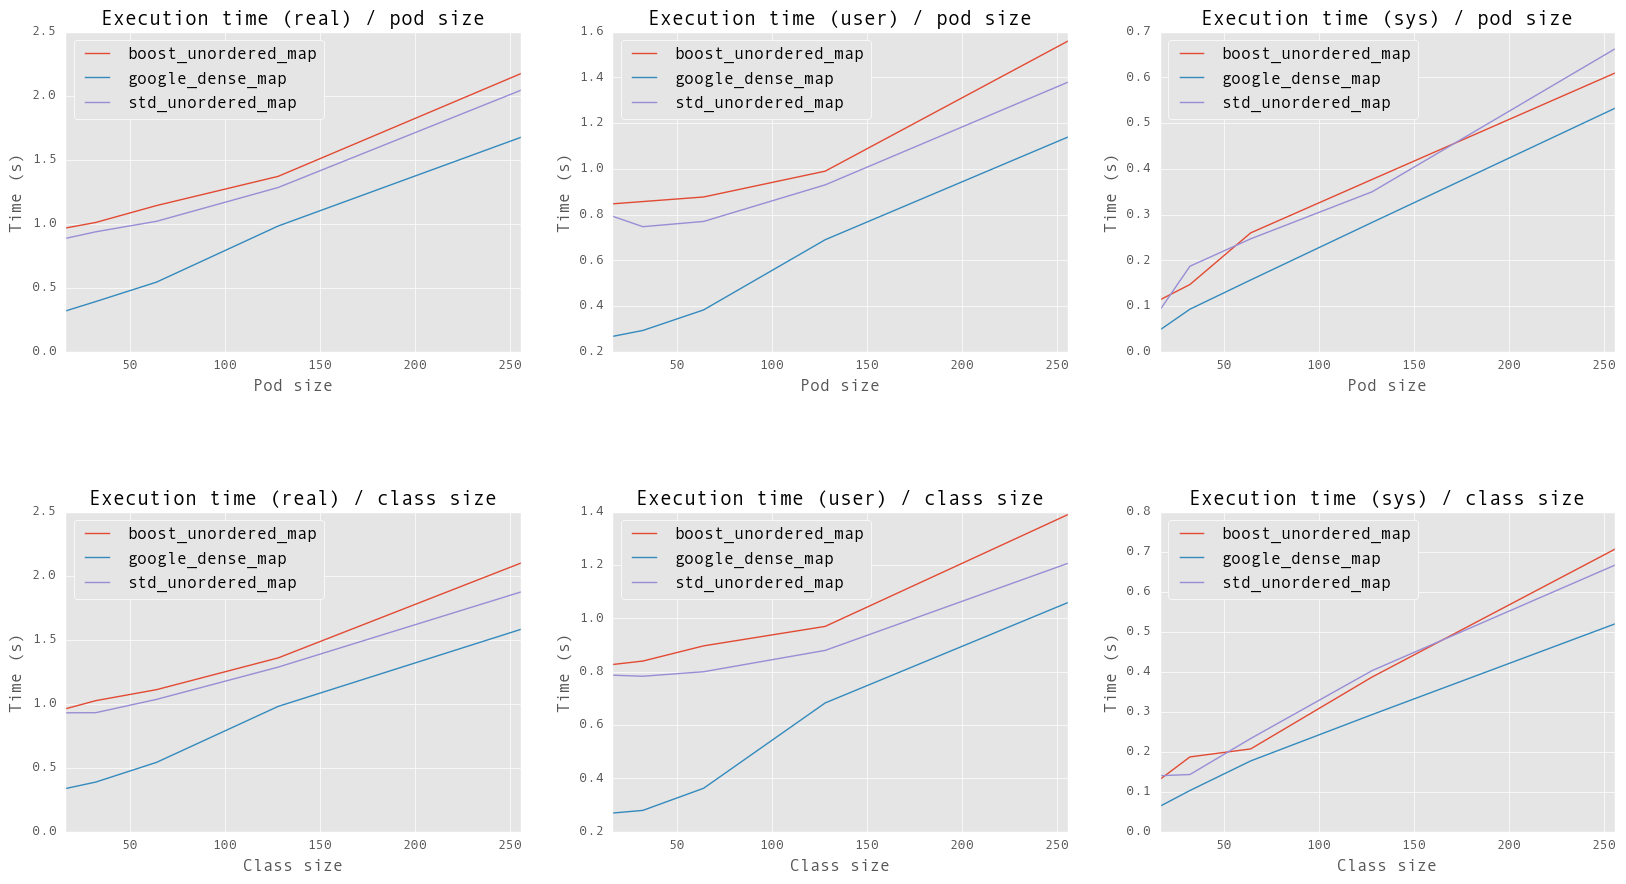

In [46]:
fname = '/home/alexis/workspace/asm_simd/test_hash_container/bench_insert2_all.txt'

value_types = ['pod', 'class']
time_types = ['real', 'user', 'sys']

fig, plots = plt.subplots(len(value_types), len(time_types))
fig.set_figwidth(20)
fig.set_figheight(10)
plots = np.ndarray.flatten(plots)

for i, time_type in enumerate(time_types):

	pod_times, class_times = parse_times_file(fname, time_type)

	pod_df = pd.DataFrame(data=pod_times)	

	plot = plots[i]
	pod_df.plot(ax=plot)

	plot.set_title('Execution time ({}) / pod size'.format(time_type))
	plot.set_xlabel('Pod size')
	plot.set_ylabel('Time (s)')

	class_df = pd.DataFrame(data=class_times)

	plot = plots[i + len(time_types)]
	class_df.plot(ax=plot)

	plot.set_title('Execution time ({}) / class size'.format(time_type))
	plot.set_xlabel('Class size')
	plot.set_ylabel('Time (s)')	

So, even with 256-bytes-wide structure, the google dense map is still
the most competitive one. Furthermore, according to the graphics
abobe, the Google dense map's execution times does not seem more
inclined than the oter solutions to increase with the contained
structure size.

# Conclusion

With a far simpler implementation, the Google dense map outmatches the
standard unordered map (a sparse hash table) in terms of insert and
lookup performance.

The main reasons are:
* The lesser cache / memory references due to the absence of pointer
  indirections mechanisms;
* The lesser count of executed instructions thanks to a far simpler
  (then smaller) code;

# Annex A: python import / init code

In [44]:
import collections
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('ggplot')

# To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)
mpl.rcParams['font.size']=10                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1    #.125

# Annex B: python code which parses basic  time output

In [45]:
def parse_times_file(fname, time_type):

    map_type = None
    pod_class = None
    u64_count = None
    
    pod_times = collections.defaultdict(dict)
    class_times = collections.defaultdict(dict)
    
    for line in open(fname):
	line = line.replace('\n', '').replace('\t', ' ').strip()
	if len(line) == 0:
	    continue
	if line.startswith('#'):
	    continue
	if 'pod' in line or 'class' in line:
	    tmp = [f.strip() for f in line.split(' ')]
	    assert(len(tmp) == 3)
	    map_type, pod_class, u64_count = tmp
	    continue
	if time_type in line:
	    tmp = [f.strip(' ') for f in line.split(' ')]
	    assert(len(tmp) == 2)
	    tmp = tmp[1].replace('0m', '').replace('s', '')
	    time = float(tmp)
	    if pod_class == 'class':
		class_times[map_type][int(u64_count) * 8] = time
	    else:
		pod_times[map_type][int(u64_count) * 8] = time

    return pod_times, class_times

In [43]:
0.274 - 0.231
240 - 227

13